<a href="https://colab.research.google.com/github/montybbk/Chest-Xray-classifier/blob/main/fast_im_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#!pip install -Uqq fastbook

In [30]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *

In [31]:
# Run if starting from scratch or changing categories
#!rm -rf MRIs

In [32]:
bing_key = '643346effad445348ef0350290511952'
key = os.environ.get('AZURE_SEARCH_KEY', bing_key)

In [33]:
results = search_images_bing(key, 'MRI ACL')
ims = results.attrgot('contentUrl')
len(ims)

150

In [34]:
dest = 'images/mri.jpg'
download_url(ims[0], dest)

Path('images/mri.jpg')

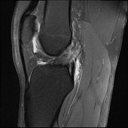

In [35]:
im = Image.open(dest)
im.to_thumb(128,128)

In [36]:
#!rm -rf MRIs

In [37]:
mri_types = 'MRnet ACL abnormal','MRnet ACL normal'
path = Path('MRIs')

In [38]:
if not path.exists(): 
    path.mkdir()
    for o in mri_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} MRI')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [39]:
fns = get_image_files(path)
fns

(#241) [Path('MRIs/MRnet ACL normal/00000043.jpg'),Path('MRIs/MRnet ACL normal/00000086.gif'),Path('MRIs/MRnet ACL normal/00000103.jpg'),Path('MRIs/MRnet ACL normal/00000036.jpg'),Path('MRIs/MRnet ACL normal/00000017.jpg'),Path('MRIs/MRnet ACL normal/00000061.gif'),Path('MRIs/MRnet ACL normal/00000136.jpg'),Path('MRIs/MRnet ACL normal/00000037.jpeg'),Path('MRIs/MRnet ACL normal/00000078.jpg'),Path('MRIs/MRnet ACL normal/00000094.jpg')...]

In [40]:
failed = verify_images(fns)
failed

(#1) [Path('MRIs/MRnet ACL normal/00000068.jpg')]

In [41]:
failed.map(Path.unlink);

In [42]:
acls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [43]:
dls = acls.dataloaders(path)

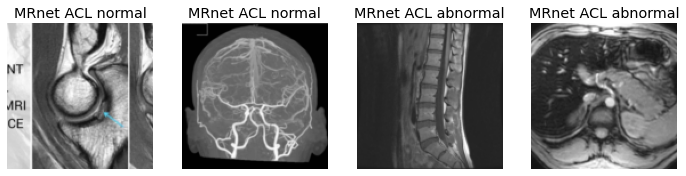

In [44]:
dls.valid.show_batch(max_n=4, nrows=1)

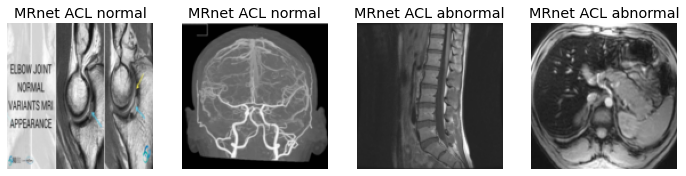

In [45]:
acls = acls.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = acls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

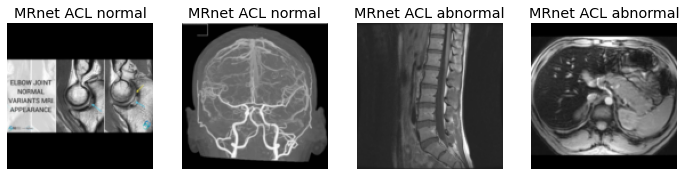

In [46]:
acls = acls.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = acls.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

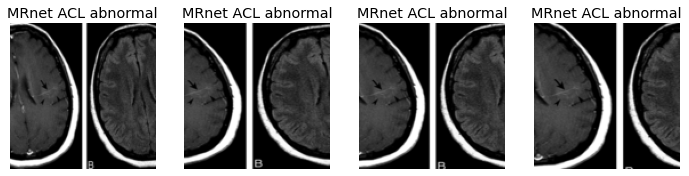

In [47]:
acls = acls.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = acls.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

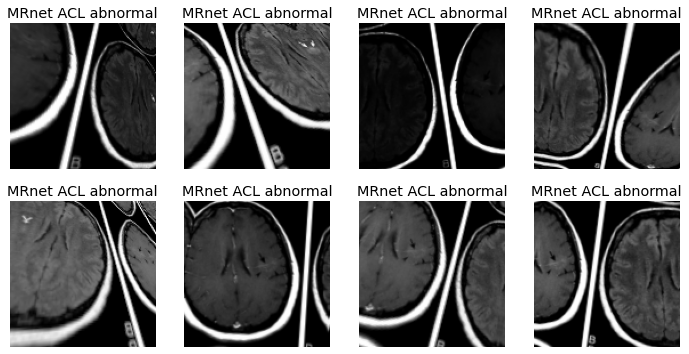

In [48]:
acls = acls.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = acls.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [49]:
acls = acls.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = acls.dataloaders(path)

In [50]:
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.172671,0.999867,0.458333,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.106252,0.981134,0.416667,00:14
1,0.967187,1.050388,0.437500,00:14
2,0.958586,1.072562,0.354167,00:13
3,0.885409,1.082469,0.375000,00:13
4,0.825589,1.136628,0.416667,00:13
5,0.764815,1.254730,0.416667,00:13
6,0.693853,1.425999,0.458333,00:14
7,0.645910,1.628164,0.520833,00:14
8,0.590660,1.983185,0.520833,00:13
9,0.558475,2.231321,0.562500,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.106252,0.981134,0.416667,00:14
1,0.967187,1.050388,0.437500,00:14
2,0.958586,1.072562,0.354167,00:13
3,0.885409,1.082469,0.375000,00:13
4,0.825589,1.136628,0.416667,00:13
5,0.764815,1.254730,0.416667,00:13
6,0.693853,1.425999,0.458333,00:14
7,0.645910,1.628164,0.520833,00:14
8,0.590660,1.983185,0.520833,00:13
9,0.558475,2.231321,0.562500,00:14


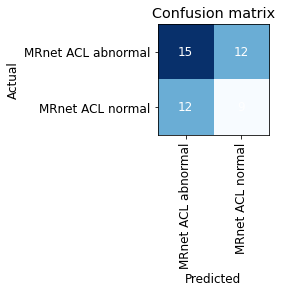

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

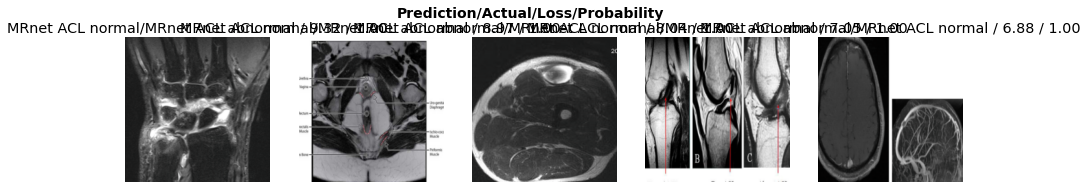

In [52]:
interp.plot_top_losses(5, nrows=1)

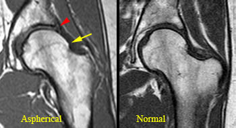

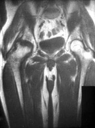

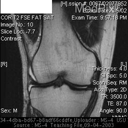

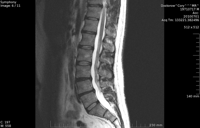

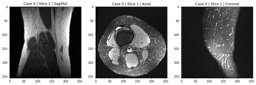

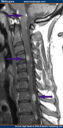

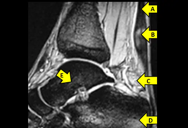

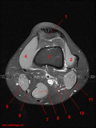

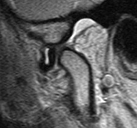

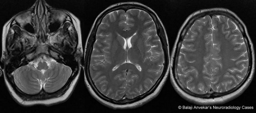

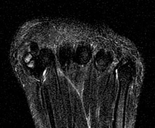

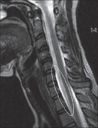

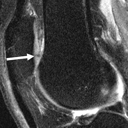

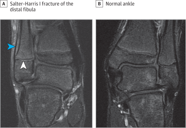

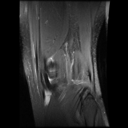

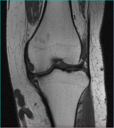

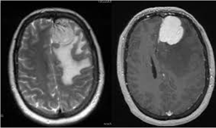

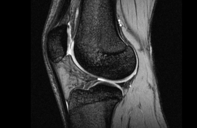

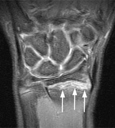

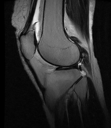

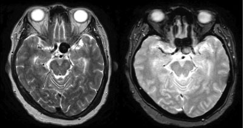

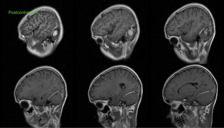

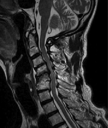

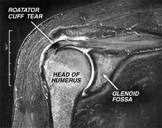

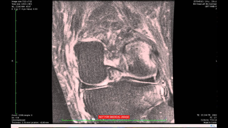

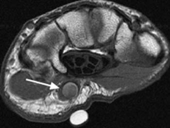

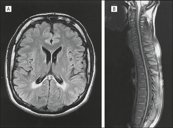

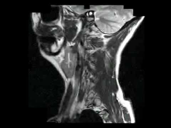

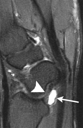

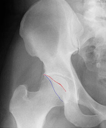

In [53]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

In [56]:
learn_inf = load_learner(path/'export.pkl')

In [57]:
learn_inf.predict('images/mri.jpg')

('MRnet ACL normal', TensorBase(1), TensorBase([0.1459, 0.8541]))

In [58]:
learn_inf.dls.vocab

['MRnet ACL abnormal', 'MRnet ACL normal']